### Ecg Digitizition tool 

2024-12-08

Troca do sistema de rotulação da imagem pelo skimage

In [36]:
import sys
import scipy
import cv2 as cv
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from PIL import Image
import skimage as ski
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import pytesseract

In [2]:
BORDER_GAP = 15 #
ECG_ROWS = 6
ECG_COLS = 2

## Functions

In [3]:
# Helper function to help display an oversized image
def display_image(image, name):
    if image.shape[0] > 1000:
        image = cv.resize(image, (0, 0), fx=0.85, fy=0.85)
    cv.imshow(name, image)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [4]:
# Helper function to sharpen the image
def sharpen(img):
    kernel = np.array([[0, -1, 0],
                        [-1, 5.5, -1],
                        [0, -1, 0]], np.float32)
    img = cv.filter2D(img, -1, kernel)
    return img

In [5]:
# Helper function to increase contrast of an image
def increase_contrast(img):
    lab_img = cv.cvtColor(img, cv.COLOR_RGB2LAB)
    l, a, b = cv.split(lab_img)
    clahe = cv.createCLAHE(clipLimit=4, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    img = cv.merge((cl, a, b))
    img = cv.cvtColor(img, cv.COLOR_LAB2RGB)
    return img

In [6]:
# Helper function to crop the image and eliminate the borders
def crop_image(image, upper, lower, left, right):
    mask = image > 0
    coords = np.argwhere(mask)
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1
    image = image[x0 + upper: x1 + lower, y0 + left: y1 + right]
    return image

In [7]:
# Another helper function to crop and remove the borders
def crop_image_v2(image, tolerance=0):
    mask = image > tolerance
    image = image[np.ix_(mask.any(1), mask.any(0))]
    return image


In [8]:
# Helper function to distinguish different ECG signals on specific image
def separate_components(image):
    ret, labels = cv.connectedComponents(image, connectivity=8)

    # mapping component labels to hue value
    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_image = cv.merge([label_hue, blank_ch, blank_ch])
    labeled_image = cv.cvtColor(labeled_image, cv.COLOR_HSV2BGR)

    # set background label to white
    labeled_image[label_hue == 0] = 255
    return labeled_image


In [9]:
# Helper function to display segmented ECG picture
def display_segments(name, item, axis='off'):
    plt.figure(figsize=(12, 9))
    plt.imshow(item, cmap="magma")
    plt.title(name)
    plt.axis(axis)
    plt.subplots_adjust(wspace=.05, left=.01, bottom=.01, right=.99, top=.9)
    plt.show()


In [10]:
# Helper function to detect characters
def ocr(image):
    text = pytesseract.image_to_string(image, lang='eng')
    return text

In [11]:
BLOCK_SIZE = 50
THRESHOLD = 25


def preprocess(image):
    image = cv.medianBlur(image, 3)
    image = cv.GaussianBlur(image, (3, 3), 0)
    return (image)

def invert_image(image):
    return (image-255)*255

def postprocess(image):
    #image = cv.medianBlur(image, 3)
    # image = cv2.medianBlur(image, 5)
    # kernel = numpy.ones((3,3), numpy.uint8)
    image = cv.morphologyEx(image, cv.MORPH_OPEN, (5,5),iterations=5)
    return image


def get_block_index(image_shape, yx, block_size): 
    y = np.arange(max(0, yx[0]-block_size), min(image_shape[0], yx[0]+block_size))
    x = np.arange(max(0, yx[1]-block_size), min(image_shape[1], yx[1]+block_size))
    return tuple(np.meshgrid(y, x))


def adaptive_median_threshold(img_in):
    med = np.median(img_in)
    img_out = np.zeros_like(img_in)
    img_out[img_in - med < THRESHOLD] = 255
    return img_out


def block_image_process(image, block_size):
    out_image = np.zeros_like(image)
    for row in range(0, image.shape[0], block_size):
        for col in range(0, image.shape[1], block_size):
            idx = (row, col)
            block_idx = get_block_index(image.shape, idx, block_size)
            out_image[block_idx] = adaptive_median_threshold(image[block_idx])

    return out_image


def process_image_file(filename):
    image_in = cv.cvtColor(cv.imread(filename), cv.COLOR_BGR2GRAY)

    image_in = preprocess(image_in)
    image_out = block_image_process(image_in, BLOCK_SIZE)
    image_out = postprocess(image_out)

    cv.imwrite('bin_' + filename, image_out)

def grid_removal(img):
    kernel = np.ones((10,10),np.uint8)
    dilation = cv.dilate(img,kernel,iterations = 1)
    return dilation
    

## Calculations

An Image scanned in 600 dpi , each point represents 0.042 mm. If one scans an A4 sheet (210 mm x 297 mm ). If you translate in points 
is 5000 X 7071.

## Main Code

### Load Image

(1044, 1235)


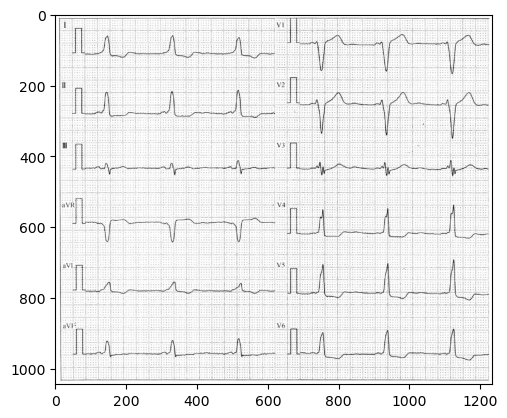

In [12]:
image_name = 'images/test3.jpg'  # select image
    #image_name = 'new/6/22 陆金明 ？/IMAGE_000018.jpg'
image = cv.imread(image_name, flags=cv.IMREAD_GRAYSCALE)  # read the image as GS
#image = cv.imread(image_name).max(axis=-1)
# sanity check
if image is None:
    print('Cannot open image: ' + image_name)
    sys.exit(0)

plt.imshow(image, cmap="gray")
print(image.shape)

### Convert to Binary

(1044, 1235)


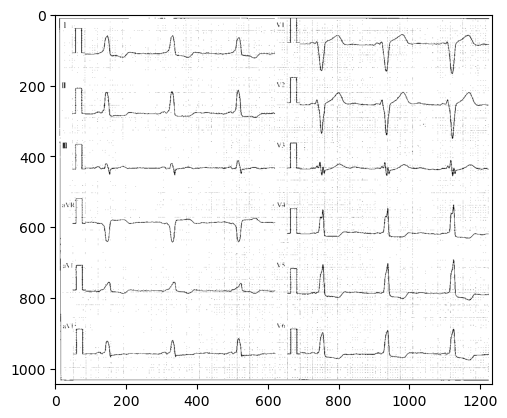

In [43]:
# use thresholding to transform the image into a binary one
ret, th1 = cv.threshold(image, 127, 255,cv.THRESH_BINARY)
plt.imshow(th1, cmap="gray")
print(th1.shape)

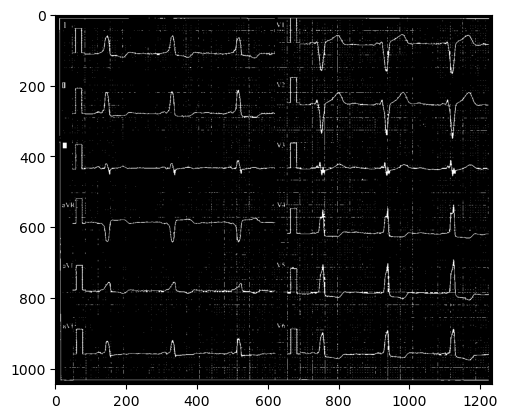

In [ ]:
# remove artifacts connected to image border
closed = closing(255-th1, square(3))
cleared = clear_border(closed,buffer_size=)
plt.imshow(cleared, cmap="gray")

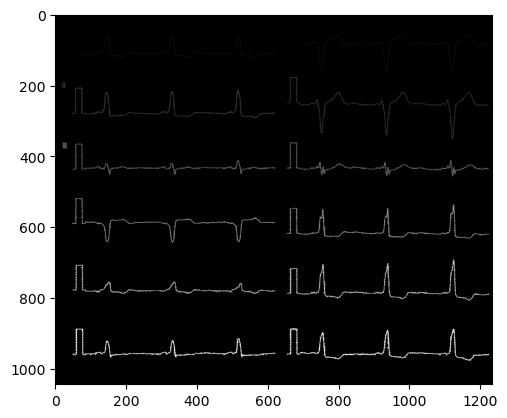

In [ ]:
# remove artifacts connected to image border
cleared = clear_border(bw)
labeled_image = ski.measure.label(foreground)

# Separate objects into regions larger and smaller than 100 pixels
clb_image = ski.morphology.remove_small_objects(labeled_image, min_size=100) # clean labeled image
plt.imshow(clb_image, cmap="gray")

### Image Recognition

Find the largest bouding box that contains the image

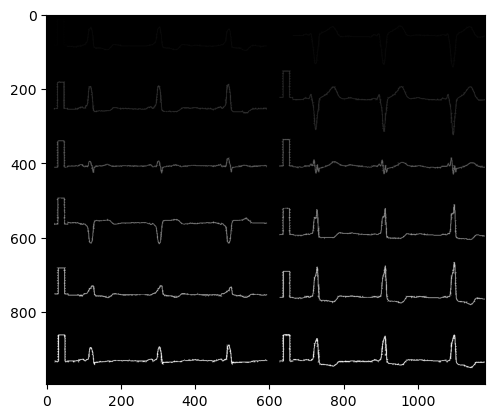

In [ ]:
foreground  = 255-th1

cleared = 

labeled_image = ski.measure.label(foreground)

# Separate objects into regions larger and smaller than 100 pixels
clb_image = ski.morphology.remove_small_objects(labeled_image, min_size=100) # clean labeled image
plt.imshow(clb_image, cmap="gray")


#structure = np.array([[1, 1, 1],
#                      [1, 1, 1],
#                      [1, 1, 1]], np.uint8)
#labeled_image, nb = ndimage.label(foreground, structure=structure)
#display_segments('Labeled Image', labeled_image)

In [32]:
u,c = np.unique(clb_image, return_counts=True) 
curve_labels = np.argsort(c[1:])[-ECG_ROWS*ECG_COLS:]+1

In [34]:
curve_labels

array([ 5, 13,  9, 10, 16, 15,  8,  4, 11,  7, 12,  6], dtype=int64)

### Under development Main part of the code for all curves

Curve 12 line range = [34, 99].
Curve 12 baseline = 55 line range = [34, 99].
Curve 12 line range = [681, 764].
8.0
Curve 12 baseline = 77 line range = [681, 764].
Curve 12 line range = [340, 429].
8.0
Curve 12 baseline = 60 line range = [340, 429].
Curve 12 line range = [494, 619].
Curve 12 baseline = 89 line range = [494, 619].
Curve 12 line range = [862, 952].
Curve 12 baseline = 74 line range = [862, 952].
Curve 12 line range = [862, 944].
9.0
Curve 12 baseline = 73 line range = [862, 944].
Curve 12 line range = [336, 432].
8.0
Curve 12 baseline = 36 line range = [336, 432].
Curve 12 line range = [31, 144].
Curve 12 baseline = 94 line range = [31, 144].
Curve 12 line range = [512, 608].
Curve 12 baseline = 71 line range = [512, 608].
Curve 12 line range = [181, 268].
8.0
Curve 12 baseline = 85 line range = [181, 268].
Curve 12 line range = [667, 783].
Curve 12 baseline = 91 line range = [667, 783].
Curve 12 line range = [152, 326].
8.0
Curve 12 baseline = 149 line range = [152, 326

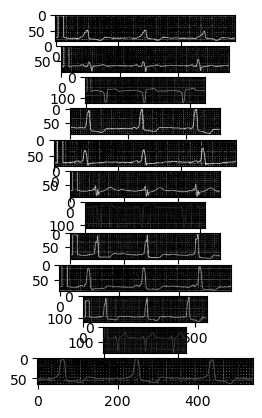

In [ ]:
#TODO

u,c = np.unique(labeled_image, return_counts=True) 
curve_labels = np.argsort(c[1:])[-ECG_ROWS*ECG_COLS:]+1

fig, axs = plt.subplots(len(curve_labels), fig)


curve_baselines = []
curve_lengths = []
curve_widths = []
curve_lower_bound = []
curve_upper_bound = []
curve_scales=[]
for i, label in enumerate(curve_labels):
        sl = ndimage.find_objects(labeled_image==label)
        roi = labeled_image[sl[0][0],sl[0][1]] # slice in x and slice in y
       
        axs[i-1].imshow(roi, cmap='gray')
        curve_widths.append(roi.shape[0])
        curve_lengths.append(roi.shape[1])
        curve_lower_bound.append(sl[0][0].stop)
        curve_upper_bound.append(sl[0][0].start)
        print("Curve {} line range = [{}, {}].".format(len(curve_labels), sl[0][0].start, sl[0][0].stop))
       

        roi_copy = roi.copy()
        roi_copy = np.where(roi_copy> 0, 0, 255) # invert roi to use match template
        roi_copy = roi_copy.astype("uint8")

        
        template = cv.imread('images/pulse.jpg', cv.IMREAD_GRAYSCALE) #load template to find the pulse
        _,new_template = cv.threshold(template,127,255,cv.THRESH_OTSU)
        w, h = new_template.shape[::-1]

        if roi_copy.shape[0] <= new_template.shape[0] or roi_copy.shape[1]<= new_template.shape[1]:
               
               #template is bigger then roi. Can not perform matchTemplate

               empty_list=[]
               empty_array = np.array(empty_list)
               loc = (empty_array,empty_array )
        else:
              res = cv.matchTemplate(roi_copy,new_template,cv.TM_CCOEFF_NORMED) # try tofind the pulse using a template match
              threshold = 0.75
              loc = np.where( res >= threshold)

        if len(loc[0])>0:
              detection = True # pulse was detected 
              ppts=np.array(list(map(list, zip(*loc[::-1])))) #obtain um array from the list of tuples
              ppts_max= ppts[:,0].max()
              ppts_min= ppts[:,0].min()
              print(np.median(ppts,axis=0)[0])
              extracted_pulse = roi_copy[:,ppts_max:ppts_max+w]
              baseline_pulse = np.argmax(np.std(extracted_pulse, axis =1))
              roi[:,ppts_max:ppts_max+w]=0 # remove pulse from roi 
              
              # Extract a retangle form the pulse to calculate the ratio mv to points dx to points
              contours, _ = cv.findContours(extracted_pulse, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
              rectangular_contours = get_rectangular_contours(contours)
              # find the biggest countour (c) by the area
              c = max(contours, key = cv.contourArea)
              x_border,y_border,w_border,h_border = cv.boundingRect(c)
              curve_scales.append((w_border,h_border))
        else:
              # No pulse detected or the roi has no pulse
              detection = False
              curve_scales.append((None,None))

        baseline = np.argmax(np.std(roi, axis =1)) # ECG baseline without reference pulse 
        curve_baselines.append(baseline)
        print("Curve {} baseline = {} line range = [{}, {}].".format(len(curve_labels),baseline, sl[0][0].start, sl[0][0].stop))
        #draw the baseline
        

       

### Tests with a single curve

In [ ]:
u,c = np.unique(clb_image, return_counts=True) 
curve_labels = np.argsort(c[1:])[-ECG_ROWS*ECG_COLS:]+1
curve_labels

In [35]:
slice_x, slice_y = ndimage.find_objects(clb_image==5)[0]
#sl = ndimage.find_objects(labeled_image==19456)
slice_x, slice_y



IndexError: list index out of range

77


array([[    0,     0,     0, ...,     0, 19516,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ...,     0,     0,     0],
       [21853,     0,     0, ...,     0, 21862, 21862],
       [21853,     0,     0, ...,     0,     0,     0]])

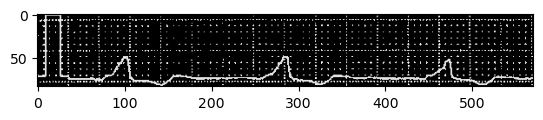

In [45]:
roi = labeled_image[slice_x,slice_y]
plt.imshow(roi,cmap = "gray")
baseline= np.argmax(np.std(roi, axis =1))
print(baseline)
roi

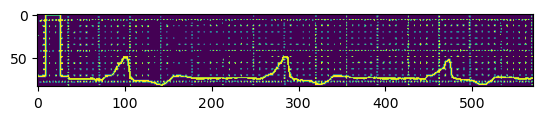

In [49]:
roi2= np.where(roi_copy > 0 , 255, 0)
plt.imshow(roi2)

In [51]:
structure = np.array([[1, 1, 1],
                      [1, 1, 1],
                      [1, 1, 1]], np.uint8)
labeled_roi, nb = ndimage.label(roi, structure=structure)
u,c = np.unique(labeled_roi, return_counts=True) 
roi_labels = np.argsort(c[1:])[-2:]+1

In [52]:
import skimage as ski
objects = ski.measure.label(roi)

# Separate objects into regions larger and smaller than 100 pixels
large_objects = ski.morphology.remove_small_objects(objects, min_size=100)

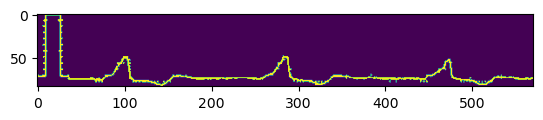

In [53]:
plt.imshow(large_objects)

In [54]:
large_objects

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

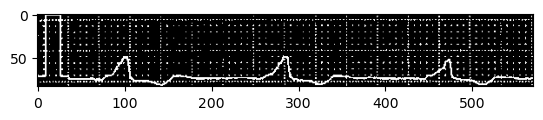

In [41]:

roi_copy = roi.copy()
roi_copy = np.where(roi_copy> 0, 255.0, 0.0)
plt.imshow(roi_copy, cmap="gray")

In [43]:
roi_copy = roi_copy.astype("uint8")
roi_copy

array([[  0,   0,   0, ...,   0, 255,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [255,   0,   0, ...,   0, 255, 255],
       [255,   0,   0, ...,   0,   0,   0]], dtype=uint8)

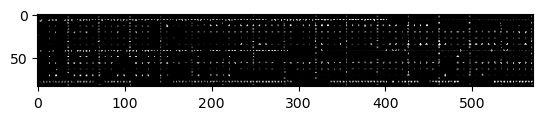

In [38]:
plt.imshow(roi_copy, cmap="gray")

(483, 55, 3, 3)

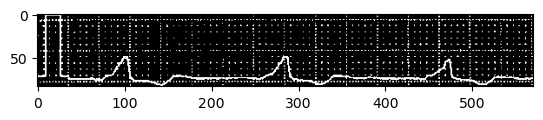

In [44]:
#find the rectangular shape
contours, _ = cv.findContours(roi_copy, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
rectangular_contours = get_rectangular_contours(contours)
c = max(rectangular_contours, key = cv.contourArea)
x_border,y_border,w_border,h_border = draw_retangle (roi_copy, c)
x_border,y_border,w_border,h_border

In [37]:

template = cv.imread('images/pulse.jpg', cv.IMREAD_GRAYSCALE)
_,new_template = cv.threshold(template,127,255,cv.THRESH_OTSU)
w, h = template.shape[::-1]



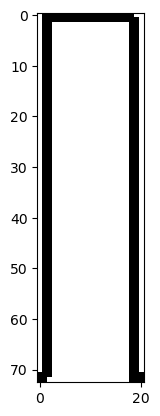

In [38]:
plt.imshow(new_template, cmap="gray")

In [39]:
new_template

array([[255,   0,   0, ...,   0, 255, 255],
       [255,   0,   0, ...,   0,   0, 255],
       [255,   0,   0, ...,   0,   0, 255],
       ...,
       [255,   0,   0, ...,   0,   0, 255],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0, 255, ...,   0,   0,   0]], dtype=uint8)

In [44]:
empty_list=[]
empty_array = np.array(empty_list)

len(empty_array)

0

In [40]:
res = cv.matchTemplate(roi_copy,new_template,cv.TM_CCOEFF_NORMED)
threshold = 0.75
loc = np.where( res >= threshold)

In [43]:
loc

(array([0, 1, 2, 7], dtype=int64), array([8, 8, 8, 8], dtype=int64))

(8, 0)
(8, 1)
(8, 2)
(8, 7)


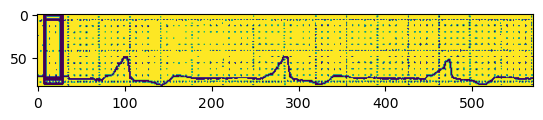

In [203]:
for pt in zip(*loc[::-1]):
    print(pt)
    cv.rectangle(roi_copy, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
 
cv.imwrite('res.png',roi_copy)
plt.imshow(roi_copy)

In [ ]:
np.median(ppts,axis=0)[1]

(83, 571)

In [219]:
#Find out where the pulse was detected


ppts=np.array(list(map(list, zip(*loc[::-1])))) #obtain um array from the list of tuples
ppts_max= ppts[:,0].max()
ppts_min= ppts[:,0].min()
print(np.median(ppts,axis=0)[0])
if np.median(ppts,axis=0)[0]< roi_copy.shape[1]/4:
    print("PULSE_LEFT")
    extracted_pulse = roi[:,ppts_max:ppts_max+w]
else:
    print("PULSE_RIGHT")

8.0
PULSE_LEFT


0


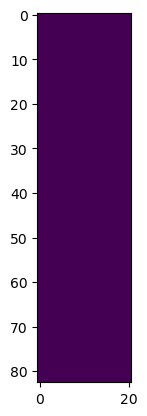

In [220]:
plt.imshow(extracted_pulse)
baseline= np.argmax(np.std(extracted_pulse, axis =1))
print(baseline)

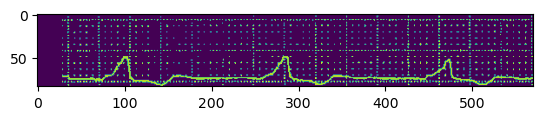

In [218]:
roi[:,0:ppts_max+w]=0
plt.imshow(roi)

array([8. , 1.5])

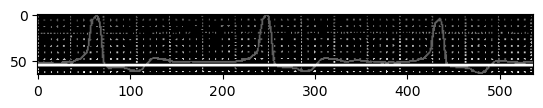

In [126]:
#draw a line
roi_copy = roi.copy()/roi.max()
line_thickness = 2
cv.line(roi_copy,(0,baseline),(roi.shape[1],baseline),color=1.0,thickness=line_thickness)
plt.imshow(roi_copy, cmap="gray")

In [115]:
roi

array([[    0,     0,     0, ...,     0,     0,     0],
       [14237, 14237,     0, ..., 14248, 14248,     0],
       [14237, 14237,     0, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0]])

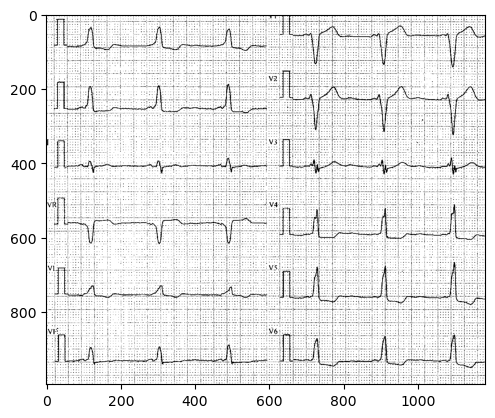

In [68]:
cutted_image = (th1)[y_border+BORDER_GAP:y_border+h_border-BORDER_GAP,
                      x_border+BORDER_GAP:x_border+w_border-BORDER_GAP].copy()
plt.imshow(cutted_image, cmap="gray")

In [70]:
cutted_image = cutted_image*255
cutted_image

array([[  0,   0, 255, ..., 255, 255, 255],
       [  0,   0, 255, ..., 255, 255, 255],
       [  0,   0, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255,   0, 255],
       [255, 255, 255, ..., 255,   0, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)